# Telecommunications

The telecom operator wants to learn how to predict customer outflow. If it turns out that the user is planning to leave, they will be offered promotional codes and special conditions. The operator’s team collected personal data about some clients, information about their tariffs and contracts.

## Loading Data

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

RANDOM_STATE=250923

In [2]:
contract=pd.read_csv('contract_new.csv')
internet=pd.read_csv('internet_new.csv')
personal=pd.read_csv('personal_new.csv')
phone=pd.read_csv('phone_new.csv')

## Dataframe Research

### Contract

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
len(contract['customerID'].unique())

7043

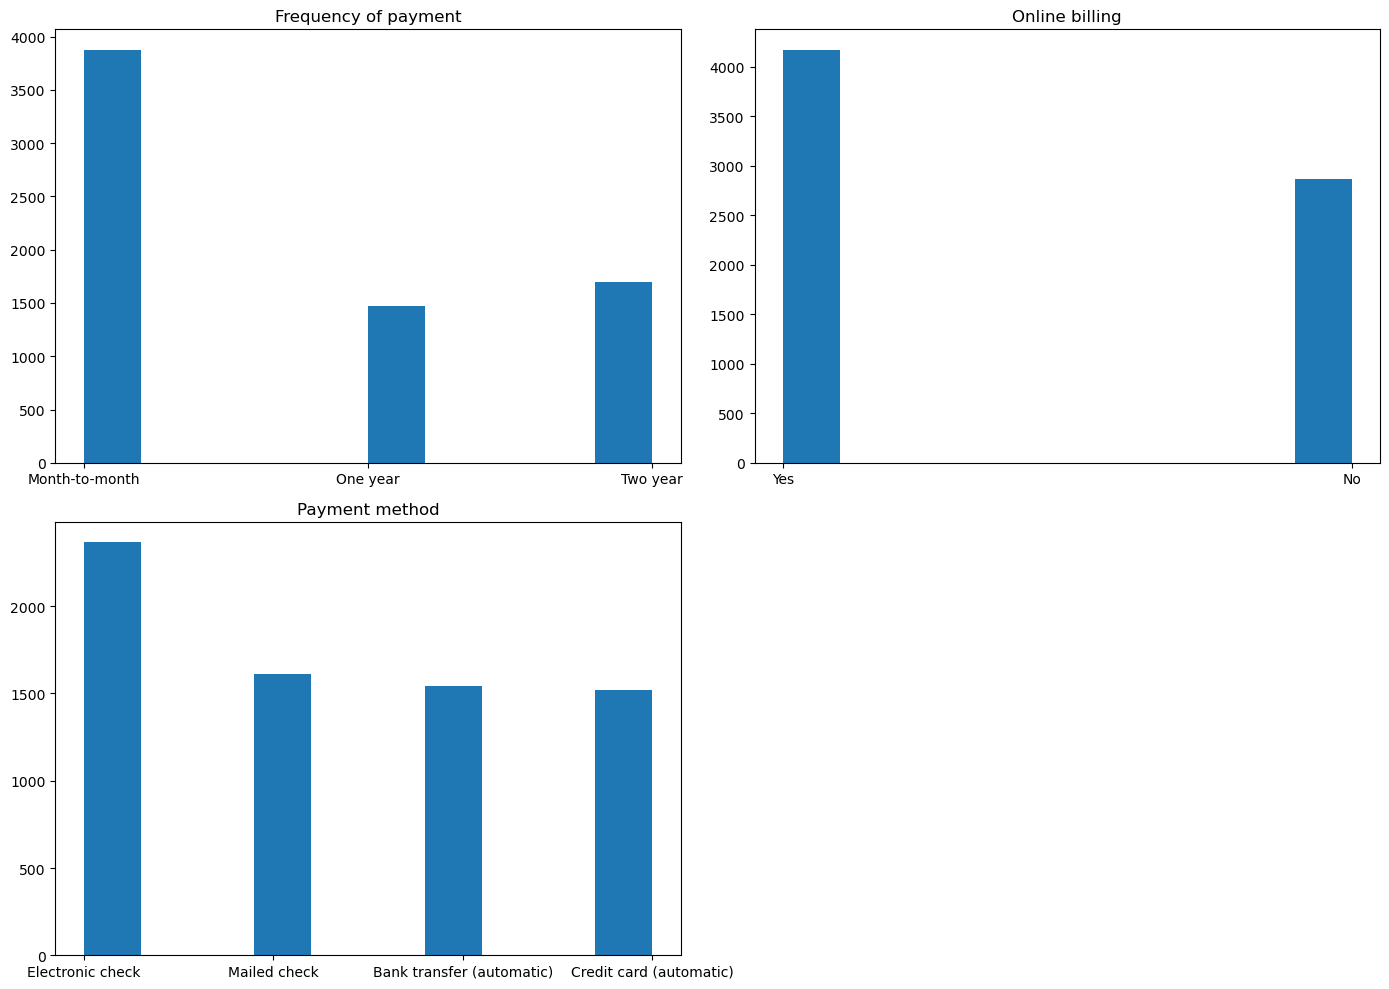

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
ax[0, 0].hist(contract['Type'])
ax[0, 0].set_title("Frequency of payment")
ax[0, 1].hist(contract['PaperlessBilling'])
ax[0, 1].set_title("Online billing")
ax[1, 0].hist(contract['PaymentMethod'])
ax[1, 0].set_title("Payment method")
fig.delaxes(ax[1][1])
plt.tight_layout()
plt.show()

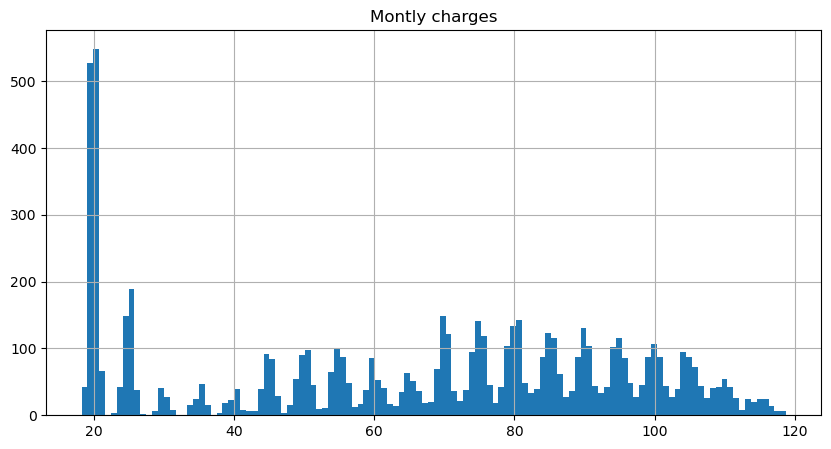

In [8]:
contract['MonthlyCharges'].hist(bins=120, figsize=(10,5))
plt.title('Montly charges')
plt.show()

In [9]:
contract.duplicated().sum()

0

In [10]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

#### Conclusion

There are no gaps or duplicates in all 4 dataframes.

The most popular form of payment is monthly, it is twice as popular as other methods. The popularity of electronic document management is visible: most users prefer to receive a payment receipt online, as well as pay without leaving home.

On the monthly payment histogram, types of peaks every 5 units, and also a maximum at a value of 20. Most likely, the minimum tariff is 20 units, and the remaining tariffs are most often multiples of 5.

You will need to change the data type of the contract start date (to datetime), as well as TotalCharges to float.

### Internet

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
len(internet['customerID'].unique())

5517

In [14]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


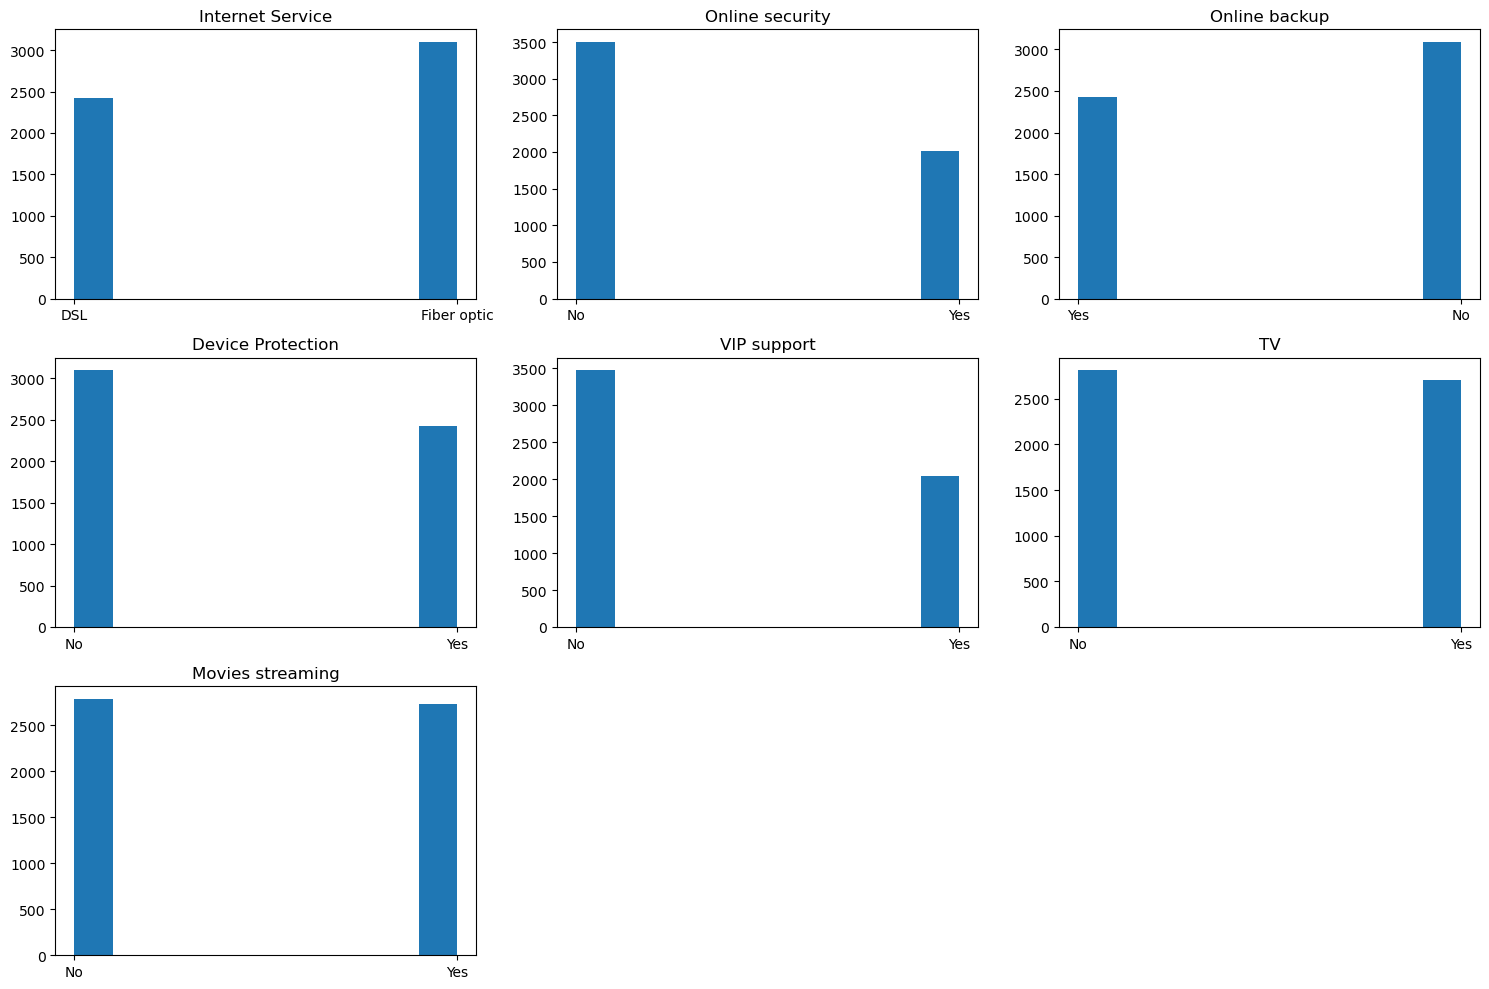

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
ax[0, 0].hist(internet['InternetService'])
ax[0, 0].set_title("Internet Service")
ax[0, 1].hist(internet['OnlineSecurity'])
ax[0, 1].set_title("Online security")
ax[0, 2].hist(internet['OnlineBackup'])
ax[0, 2].set_title("Online backup")
ax[1, 0].hist(internet['DeviceProtection'])
ax[1, 0].set_title("Device Protection")
ax[1, 1].hist(internet['TechSupport'])
ax[1, 1].set_title("VIP support")
ax[1, 2].hist(internet['StreamingTV'])
ax[1, 2].set_title("TV")
ax[2, 0].hist(internet['StreamingMovies'])
ax[2, 0].set_title("Movies streaming")
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
plt.tight_layout()
plt.show()

In [16]:
internet.duplicated().sum()

0

In [17]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

#### Conclusion

Fiber optic connections are more popular than DSL, which is understandable, since providers are increasingly switching to modern technology.

Less than half of users use additional services (antivirus, cloud storage, etc.).

### Personal

In [18]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [19]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
len(personal['customerID'].unique())

7043

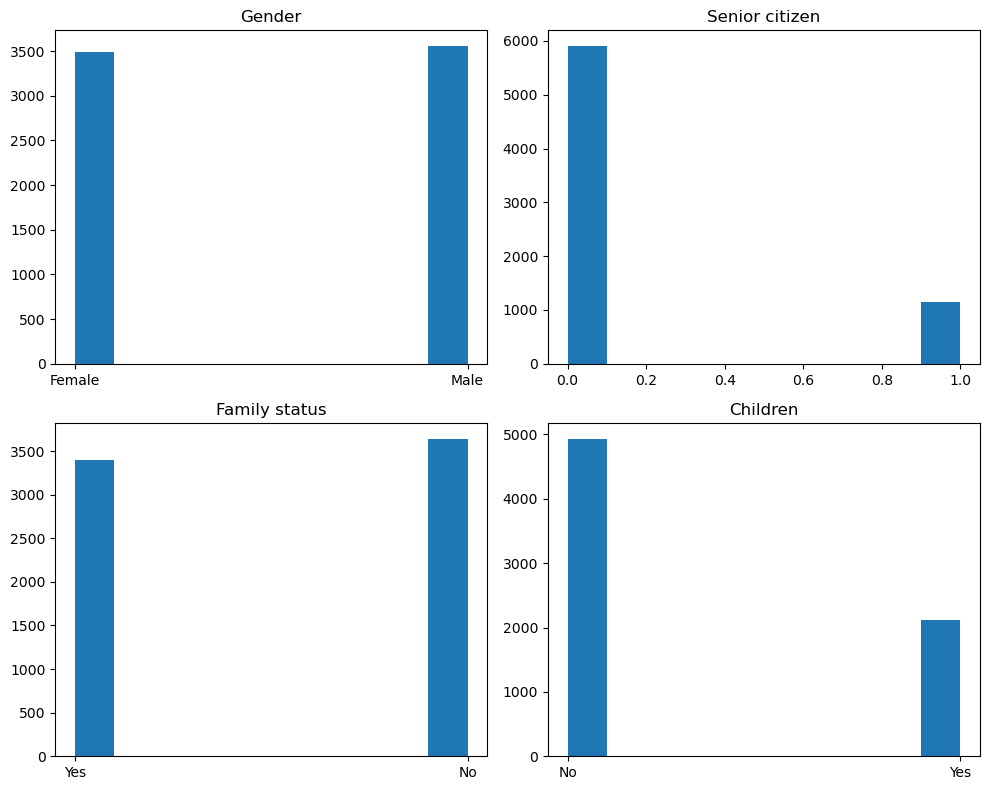

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].hist(personal['gender'])
ax[0, 0].set_title("Gender")
ax[0, 1].hist(personal['SeniorCitizen'])
ax[0, 1].set_title("Senior citizen")
ax[1, 0].hist(personal['Partner'])
ax[1, 0].set_title("Family status")
ax[1, 1].hist(personal['Dependents'])
ax[1, 1].set_title("Children")
plt.tight_layout()
plt.show()

In [22]:
personal.duplicated().sum()

0

In [23]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

#### Conclusion

Men and women connect to the Internet equally. The proportion of families and single people is almost equal. About a third of clients have children. Pensioners make up 1/7 of the total number of clients, which corresponds to the age pyramid of the population.

### Phone

In [24]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [25]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [26]:
len(phone['customerID'].unique())

6361

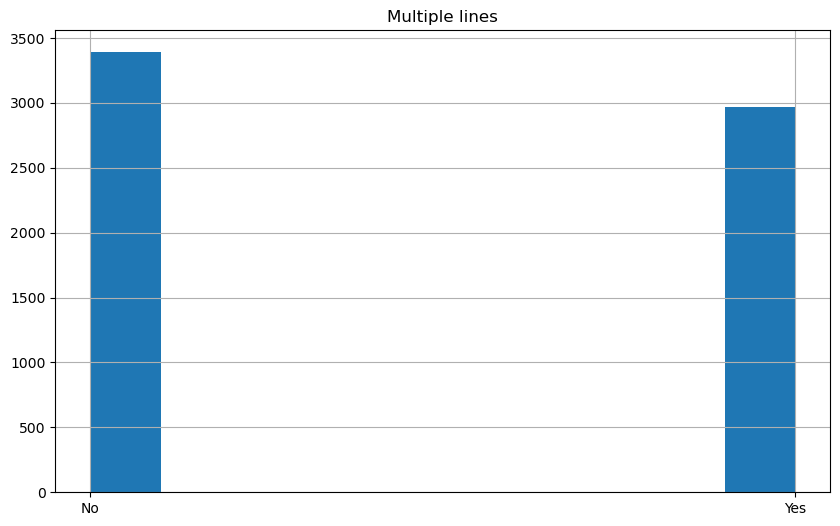

In [27]:
phone['MultipleLines'].hist(figsize=(10,6))
plt.title("Multiple lines")
plt.show()

In [28]:
phone.duplicated().sum()

0

In [29]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

#### Conclusion

Slightly less than half of clients use several lines at the same time.

Another important point that applies to all 4 dataframes is that the clients in each of them are not repeated, which eliminates moments when different information is present for one client.

The source databases are of high quality, but with a small number of rows (7000). Selecting hyperparameters for models will be more important than ever.

## Work plan

1. Combining 4 dataframes into a single one. We will merge based on the customerID column
2. Preprocessing. We will need to change data types, create a column with a target parameter, and work with gaps.
3. Dividing into samples test_size=0.25
4. Coding and scaling of features.
5. Machine learning. I will use 3 models: Logistic regression, CatBoost and LightGBM. Selection of hyperparameters
6. Checking the best model on a test sample.
7. Determining the importance of features for the best model.

### Questions to teamlead

1. The personal table has a SeniorCitizen column. Unlike other object columns, this one is of type int. Although it has the same yes/no function. Is it necessary to cast to object or is there no difference for the MO?


2. Do I understand correctly that we create the target attribute as a separate column based on beginDate? If No then 0, if there is a date 1.

# Merging dataframes

In [30]:
df=contract.merge(internet, how='left', on='customerID')
df=df.merge(personal, how='left', on='customerID')
df=df.merge(phone, how='left', on='customerID')

In [31]:
df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


## Preprocessing

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [33]:
df.duplicated().sum()

0

In [34]:
df=df.fillna('No')

In [35]:
df['TotalCharges'].isna().sum()

0

In [36]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors ='coerce')

In [37]:
df = df[df['TotalCharges'].notna()]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  gender            7032 non-null   object 
 16  SeniorCitizen     7032 non-null   int64  
 17  

In [39]:
df['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [40]:
df['lost_client'] = np.where(df['EndDate']== 'No', 0, 1)

In [41]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['EndDate'] = df['EndDate'].fillna(datetime(2020, 2, 1))
df['days']=df['EndDate']-df['BeginDate']
df['days']=df['days'].dt.days
df['days']=df['days']

In [42]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,lost_client,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,Female,0,No,No,No,0,153


In [43]:
df=df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)

### Data sampling

In [44]:
features=df.drop('lost_client', axis=1)
target=df['lost_client']

In [45]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [46]:
print(features_train.shape[0])
print(target_train.shape[0])
print()
print(features_test.shape[0])
print(target_test.shape[0])

5274
5274

1758
1758


### Encoding and scaling

In [47]:
num_features=features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')

In [48]:
num_features

['MonthlyCharges', 'TotalCharges', 'days']

In [49]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

features_train_ohe = features_train.copy()
features_test_ohe= features_test.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[ohe_features])

features_train_ohe[encoder_ohe.get_feature_names_out()]=encoder_ohe.transform(features_train_ohe[ohe_features])

features_train_ohe=features_train_ohe.drop(ohe_features, axis=1)

scaler = StandardScaler()

features_train_ohe[num_features]=scaler.fit_transform(features_train_ohe[num_features])

features_train_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
4571,0.164162,-0.303474,0,-0.433285,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
461,0.152492,-0.939718,0,-1.238600,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5284,-0.639418,-0.817669,1,-0.966751,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1190,1.332854,0.926056,0,0.366184,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3350,-0.691101,-0.923923,0,-1.145061,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
features_test_ohe[encoder_ohe.get_feature_names_out()]=encoder_ohe.transform(features_test_ohe[ohe_features])

features_test_ohe=features_test_ohe.drop(ohe_features, axis=1)

features_test_ohe[num_features]=scaler.transform(features_test_ohe[num_features])

features_test_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
6737,1.479566,1.240826,0,0.541570,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
2327,0.694325,0.074004,1,-0.167282,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4631,0.921061,-0.702098,0,-1.010598,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2437,-0.115924,-0.804649,0,-1.010598,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7009,0.537610,0.054012,0,-0.123436,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [51]:
sc_features=['MonthlyCharges', 'TotalCharges', 'days']
scaler = StandardScaler()
scaler.fit(features_train[sc_features])
features_train[sc_features] = scaler.transform(features_train[sc_features])
features_test[sc_features] = scaler.transform(features_test[sc_features])

## Model training

### Logistic Regression

In [52]:
%%time
model_log = LogisticRegression(random_state=RANDOM_STATE)
hyperparams = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100]
}
lr=GridSearchCV(model_log, hyperparams, cv=5, scoring='roc_auc')
lr.fit(features_train_ohe, target_train)

CPU times: total: 750 ms
Wall time: 777 ms


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=250923),
             param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [53]:
print("Best parameters:", lr.best_params_)
print("Best score:", lr.best_score_)

Best parameters: {'C': 100, 'penalty': 'l2'}
Best score: 0.7645959534418745


### Catboost

In [54]:
cat_columns = features_train.select_dtypes('object').columns.to_list()

In [55]:
cb_classifier = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_columns, auto_class_weights='Balanced')

hyperparams = {'learning_rate':[0.1, 0.3],
               'iterations':[200],
               'depth':[1, 2, 3]}

cat_boost = GridSearchCV(cb_classifier, hyperparams, cv=5, scoring='roc_auc')
cat_boost.fit(features_train, target_train)

0:	learn: 0.6839815	total: 177ms	remaining: 35.3s
1:	learn: 0.6784572	total: 181ms	remaining: 17.9s
2:	learn: 0.6722451	total: 189ms	remaining: 12.4s
3:	learn: 0.6681751	total: 197ms	remaining: 9.65s
4:	learn: 0.6636158	total: 205ms	remaining: 7.99s
5:	learn: 0.6589698	total: 214ms	remaining: 6.92s
6:	learn: 0.6498599	total: 224ms	remaining: 6.17s
7:	learn: 0.6465521	total: 232ms	remaining: 5.58s
8:	learn: 0.6413767	total: 241ms	remaining: 5.12s
9:	learn: 0.6389986	total: 246ms	remaining: 4.67s
10:	learn: 0.6354046	total: 255ms	remaining: 4.38s
11:	learn: 0.6300575	total: 264ms	remaining: 4.13s
12:	learn: 0.6273872	total: 272ms	remaining: 3.91s
13:	learn: 0.6238131	total: 281ms	remaining: 3.73s
14:	learn: 0.6203412	total: 289ms	remaining: 3.56s
15:	learn: 0.6176786	total: 297ms	remaining: 3.41s
16:	learn: 0.6145262	total: 305ms	remaining: 3.28s
17:	learn: 0.6119667	total: 313ms	remaining: 3.17s
18:	learn: 0.6077617	total: 321ms	remaining: 3.06s
19:	learn: 0.6050639	total: 329ms	remaini

164:	learn: 0.4962286	total: 1.62s	remaining: 343ms
165:	learn: 0.4960211	total: 1.63s	remaining: 334ms
166:	learn: 0.4958579	total: 1.64s	remaining: 324ms
167:	learn: 0.4957171	total: 1.65s	remaining: 314ms
168:	learn: 0.4955598	total: 1.65s	remaining: 303ms
169:	learn: 0.4954325	total: 1.66s	remaining: 293ms
170:	learn: 0.4952846	total: 1.67s	remaining: 283ms
171:	learn: 0.4952012	total: 1.68s	remaining: 274ms
172:	learn: 0.4950566	total: 1.69s	remaining: 264ms
173:	learn: 0.4948940	total: 1.7s	remaining: 254ms
174:	learn: 0.4947413	total: 1.71s	remaining: 244ms
175:	learn: 0.4946011	total: 1.72s	remaining: 234ms
176:	learn: 0.4944661	total: 1.73s	remaining: 224ms
177:	learn: 0.4943377	total: 1.74s	remaining: 215ms
178:	learn: 0.4943374	total: 1.75s	remaining: 205ms
179:	learn: 0.4942084	total: 1.75s	remaining: 195ms
180:	learn: 0.4940811	total: 1.76s	remaining: 185ms
181:	learn: 0.4939520	total: 1.77s	remaining: 175ms
182:	learn: 0.4937264	total: 1.78s	remaining: 166ms
183:	learn: 0

140:	learn: 0.5003697	total: 1.25s	remaining: 522ms
141:	learn: 0.5002007	total: 1.26s	remaining: 513ms
142:	learn: 0.4999557	total: 1.26s	remaining: 504ms
143:	learn: 0.4997396	total: 1.27s	remaining: 495ms
144:	learn: 0.4994910	total: 1.28s	remaining: 486ms
145:	learn: 0.4992070	total: 1.29s	remaining: 477ms
146:	learn: 0.4990102	total: 1.3s	remaining: 468ms
147:	learn: 0.4988842	total: 1.31s	remaining: 459ms
148:	learn: 0.4986897	total: 1.32s	remaining: 451ms
149:	learn: 0.4984672	total: 1.33s	remaining: 442ms
150:	learn: 0.4982962	total: 1.33s	remaining: 433ms
151:	learn: 0.4980936	total: 1.34s	remaining: 425ms
152:	learn: 0.4978990	total: 1.35s	remaining: 416ms
153:	learn: 0.4977082	total: 1.36s	remaining: 407ms
154:	learn: 0.4976989	total: 1.37s	remaining: 398ms
155:	learn: 0.4975207	total: 1.38s	remaining: 389ms
156:	learn: 0.4973248	total: 1.39s	remaining: 380ms
157:	learn: 0.4972235	total: 1.4s	remaining: 371ms
158:	learn: 0.4970737	total: 1.41s	remaining: 362ms
159:	learn: 0.

121:	learn: 0.5102101	total: 1.04s	remaining: 668ms
122:	learn: 0.5099771	total: 1.05s	remaining: 661ms
123:	learn: 0.5096973	total: 1.06s	remaining: 653ms
124:	learn: 0.5094322	total: 1.07s	remaining: 645ms
125:	learn: 0.5091909	total: 1.08s	remaining: 636ms
126:	learn: 0.5089897	total: 1.09s	remaining: 627ms
127:	learn: 0.5087291	total: 1.1s	remaining: 619ms
128:	learn: 0.5087280	total: 1.11s	remaining: 611ms
129:	learn: 0.5085641	total: 1.12s	remaining: 603ms
130:	learn: 0.5083498	total: 1.13s	remaining: 594ms
131:	learn: 0.5081213	total: 1.14s	remaining: 585ms
132:	learn: 0.5078978	total: 1.15s	remaining: 577ms
133:	learn: 0.5077576	total: 1.16s	remaining: 569ms
134:	learn: 0.5069118	total: 1.16s	remaining: 561ms
135:	learn: 0.5067026	total: 1.17s	remaining: 552ms
136:	learn: 0.5064809	total: 1.18s	remaining: 544ms
137:	learn: 0.5062752	total: 1.19s	remaining: 535ms
138:	learn: 0.5060992	total: 1.2s	remaining: 528ms
139:	learn: 0.5058926	total: 1.21s	remaining: 519ms
140:	learn: 0.

100:	learn: 0.5217637	total: 893ms	remaining: 875ms
101:	learn: 0.5217589	total: 900ms	remaining: 865ms
102:	learn: 0.5213579	total: 910ms	remaining: 857ms
103:	learn: 0.5206230	total: 920ms	remaining: 849ms
104:	learn: 0.5202059	total: 928ms	remaining: 840ms
105:	learn: 0.5198683	total: 937ms	remaining: 831ms
106:	learn: 0.5195295	total: 946ms	remaining: 822ms
107:	learn: 0.5192126	total: 954ms	remaining: 813ms
108:	learn: 0.5189143	total: 964ms	remaining: 804ms
109:	learn: 0.5186065	total: 974ms	remaining: 797ms
110:	learn: 0.5184220	total: 982ms	remaining: 788ms
111:	learn: 0.5181159	total: 991ms	remaining: 778ms
112:	learn: 0.5178115	total: 999ms	remaining: 769ms
113:	learn: 0.5175511	total: 1.01s	remaining: 760ms
114:	learn: 0.5171389	total: 1.01s	remaining: 750ms
115:	learn: 0.5165504	total: 1.02s	remaining: 742ms
116:	learn: 0.5162477	total: 1.03s	remaining: 734ms
117:	learn: 0.5159820	total: 1.04s	remaining: 725ms
118:	learn: 0.5157063	total: 1.05s	remaining: 717ms
119:	learn: 

59:	learn: 0.5483209	total: 513ms	remaining: 1.2s
60:	learn: 0.5450435	total: 522ms	remaining: 1.19s
61:	learn: 0.5444568	total: 531ms	remaining: 1.18s
62:	learn: 0.5439337	total: 539ms	remaining: 1.17s
63:	learn: 0.5432819	total: 549ms	remaining: 1.17s
64:	learn: 0.5417164	total: 559ms	remaining: 1.16s
65:	learn: 0.5412307	total: 567ms	remaining: 1.15s
66:	learn: 0.5408377	total: 576ms	remaining: 1.14s
67:	learn: 0.5400156	total: 584ms	remaining: 1.13s
68:	learn: 0.5395097	total: 593ms	remaining: 1.13s
69:	learn: 0.5385159	total: 602ms	remaining: 1.12s
70:	learn: 0.5382300	total: 610ms	remaining: 1.11s
71:	learn: 0.5375250	total: 618ms	remaining: 1.1s
72:	learn: 0.5366194	total: 628ms	remaining: 1.09s
73:	learn: 0.5360708	total: 636ms	remaining: 1.08s
74:	learn: 0.5337272	total: 648ms	remaining: 1.08s
75:	learn: 0.5331379	total: 659ms	remaining: 1.07s
76:	learn: 0.5323758	total: 667ms	remaining: 1.06s
77:	learn: 0.5300000	total: 677ms	remaining: 1.06s
78:	learn: 0.5298902	total: 686ms

36:	learn: 0.5097456	total: 317ms	remaining: 1.4s
37:	learn: 0.5088072	total: 326ms	remaining: 1.39s
38:	learn: 0.5082795	total: 335ms	remaining: 1.38s
39:	learn: 0.5075853	total: 343ms	remaining: 1.37s
40:	learn: 0.5067971	total: 351ms	remaining: 1.36s
41:	learn: 0.5061854	total: 361ms	remaining: 1.36s
42:	learn: 0.5056623	total: 370ms	remaining: 1.35s
43:	learn: 0.5056086	total: 380ms	remaining: 1.35s
44:	learn: 0.5047243	total: 388ms	remaining: 1.34s
45:	learn: 0.5040558	total: 397ms	remaining: 1.33s
46:	learn: 0.5035849	total: 405ms	remaining: 1.32s
47:	learn: 0.5031011	total: 413ms	remaining: 1.31s
48:	learn: 0.5024777	total: 422ms	remaining: 1.3s
49:	learn: 0.5014896	total: 430ms	remaining: 1.29s
50:	learn: 0.5009515	total: 438ms	remaining: 1.28s
51:	learn: 0.5002754	total: 447ms	remaining: 1.27s
52:	learn: 0.4971160	total: 458ms	remaining: 1.27s
53:	learn: 0.4965260	total: 466ms	remaining: 1.26s
54:	learn: 0.4959702	total: 477ms	remaining: 1.26s
55:	learn: 0.4955058	total: 487ms

199:	learn: 0.4736359	total: 1.78s	remaining: 0us
0:	learn: 0.6775497	total: 4.54ms	remaining: 904ms
1:	learn: 0.6577299	total: 9.16ms	remaining: 907ms
2:	learn: 0.6418478	total: 17.9ms	remaining: 1.17s
3:	learn: 0.6325949	total: 26.4ms	remaining: 1.29s
4:	learn: 0.6184266	total: 35.4ms	remaining: 1.38s
5:	learn: 0.6082571	total: 39.6ms	remaining: 1.28s
6:	learn: 0.5954097	total: 49.2ms	remaining: 1.36s
7:	learn: 0.5890679	total: 57.3ms	remaining: 1.38s
8:	learn: 0.5763080	total: 67ms	remaining: 1.42s
9:	learn: 0.5710133	total: 75.8ms	remaining: 1.44s
10:	learn: 0.5666911	total: 84.6ms	remaining: 1.45s
11:	learn: 0.5623856	total: 93.2ms	remaining: 1.46s
12:	learn: 0.5594128	total: 101ms	remaining: 1.46s
13:	learn: 0.5564180	total: 110ms	remaining: 1.46s
14:	learn: 0.5511516	total: 119ms	remaining: 1.47s
15:	learn: 0.5472348	total: 128ms	remaining: 1.47s
16:	learn: 0.5451680	total: 137ms	remaining: 1.47s
17:	learn: 0.5402712	total: 145ms	remaining: 1.47s
18:	learn: 0.5365209	total: 155m

177:	learn: 0.4684348	total: 1.56s	remaining: 193ms
178:	learn: 0.4684272	total: 1.57s	remaining: 184ms
179:	learn: 0.4683863	total: 1.58s	remaining: 176ms
180:	learn: 0.4683131	total: 1.59s	remaining: 167ms
181:	learn: 0.4682650	total: 1.6s	remaining: 158ms
182:	learn: 0.4681710	total: 1.61s	remaining: 149ms
183:	learn: 0.4681710	total: 1.62s	remaining: 141ms
184:	learn: 0.4680867	total: 1.63s	remaining: 132ms
185:	learn: 0.4680145	total: 1.64s	remaining: 123ms
186:	learn: 0.4679142	total: 1.65s	remaining: 115ms
187:	learn: 0.4677972	total: 1.66s	remaining: 106ms
188:	learn: 0.4677432	total: 1.67s	remaining: 97ms
189:	learn: 0.4676376	total: 1.67s	remaining: 88.1ms
190:	learn: 0.4676170	total: 1.68s	remaining: 79.2ms
191:	learn: 0.4675442	total: 1.69s	remaining: 70.5ms
192:	learn: 0.4674629	total: 1.7s	remaining: 61.6ms
193:	learn: 0.4673781	total: 1.71s	remaining: 52.8ms
194:	learn: 0.4673051	total: 1.72s	remaining: 44ms
195:	learn: 0.4671885	total: 1.73s	remaining: 35.2ms
196:	learn

141:	learn: 0.4796324	total: 1.23s	remaining: 501ms
142:	learn: 0.4794901	total: 1.23s	remaining: 492ms
143:	learn: 0.4793910	total: 1.24s	remaining: 484ms
144:	learn: 0.4792546	total: 1.25s	remaining: 475ms
145:	learn: 0.4791562	total: 1.26s	remaining: 466ms
146:	learn: 0.4790901	total: 1.27s	remaining: 458ms
147:	learn: 0.4789828	total: 1.28s	remaining: 449ms
148:	learn: 0.4789107	total: 1.29s	remaining: 441ms
149:	learn: 0.4788249	total: 1.29s	remaining: 432ms
150:	learn: 0.4787425	total: 1.3s	remaining: 423ms
151:	learn: 0.4786378	total: 1.31s	remaining: 414ms
152:	learn: 0.4786172	total: 1.32s	remaining: 406ms
153:	learn: 0.4785146	total: 1.33s	remaining: 397ms
154:	learn: 0.4784523	total: 1.34s	remaining: 389ms
155:	learn: 0.4783683	total: 1.35s	remaining: 380ms
156:	learn: 0.4782388	total: 1.35s	remaining: 371ms
157:	learn: 0.4781510	total: 1.36s	remaining: 363ms
158:	learn: 0.4781250	total: 1.38s	remaining: 355ms
159:	learn: 0.4780297	total: 1.39s	remaining: 347ms
160:	learn: 0

119:	learn: 0.4879597	total: 1.04s	remaining: 695ms
120:	learn: 0.4877998	total: 1.05s	remaining: 686ms
121:	learn: 0.4876336	total: 1.06s	remaining: 678ms
122:	learn: 0.4874644	total: 1.07s	remaining: 668ms
123:	learn: 0.4873244	total: 1.08s	remaining: 660ms
124:	learn: 0.4872076	total: 1.08s	remaining: 652ms
125:	learn: 0.4870497	total: 1.09s	remaining: 643ms
126:	learn: 0.4869237	total: 1.1s	remaining: 635ms
127:	learn: 0.4867775	total: 1.11s	remaining: 626ms
128:	learn: 0.4865503	total: 1.12s	remaining: 617ms
129:	learn: 0.4863991	total: 1.13s	remaining: 609ms
130:	learn: 0.4863799	total: 1.14s	remaining: 600ms
131:	learn: 0.4863797	total: 1.15s	remaining: 591ms
132:	learn: 0.4862457	total: 1.16s	remaining: 583ms
133:	learn: 0.4861276	total: 1.17s	remaining: 574ms
134:	learn: 0.4860138	total: 1.17s	remaining: 565ms
135:	learn: 0.4859680	total: 1.18s	remaining: 556ms
136:	learn: 0.4858794	total: 1.19s	remaining: 548ms
137:	learn: 0.4854016	total: 1.2s	remaining: 539ms
138:	learn: 0.

94:	learn: 0.4875642	total: 822ms	remaining: 908ms
95:	learn: 0.4875623	total: 831ms	remaining: 900ms
96:	learn: 0.4875187	total: 840ms	remaining: 892ms
97:	learn: 0.4872681	total: 850ms	remaining: 885ms
98:	learn: 0.4869858	total: 859ms	remaining: 876ms
99:	learn: 0.4865684	total: 868ms	remaining: 868ms
100:	learn: 0.4865476	total: 877ms	remaining: 860ms
101:	learn: 0.4863994	total: 886ms	remaining: 851ms
102:	learn: 0.4860920	total: 894ms	remaining: 842ms
103:	learn: 0.4858815	total: 903ms	remaining: 833ms
104:	learn: 0.4857030	total: 912ms	remaining: 825ms
105:	learn: 0.4854827	total: 921ms	remaining: 817ms
106:	learn: 0.4851274	total: 929ms	remaining: 808ms
107:	learn: 0.4849406	total: 938ms	remaining: 799ms
108:	learn: 0.4847885	total: 946ms	remaining: 790ms
109:	learn: 0.4847789	total: 954ms	remaining: 781ms
110:	learn: 0.4846329	total: 963ms	remaining: 772ms
111:	learn: 0.4845204	total: 971ms	remaining: 763ms
112:	learn: 0.4845204	total: 979ms	remaining: 754ms
113:	learn: 0.4845

59:	learn: 0.4972690	total: 894ms	remaining: 2.09s
60:	learn: 0.4955770	total: 910ms	remaining: 2.07s
61:	learn: 0.4951205	total: 925ms	remaining: 2.06s
62:	learn: 0.4947908	total: 941ms	remaining: 2.04s
63:	learn: 0.4945557	total: 956ms	remaining: 2.03s
64:	learn: 0.4942857	total: 970ms	remaining: 2.02s
65:	learn: 0.4939380	total: 985ms	remaining: 2s
66:	learn: 0.4933980	total: 999ms	remaining: 1.98s
67:	learn: 0.4932218	total: 1.01s	remaining: 1.97s
68:	learn: 0.4922581	total: 1.03s	remaining: 1.96s
69:	learn: 0.4920248	total: 1.05s	remaining: 1.95s
70:	learn: 0.4917628	total: 1.06s	remaining: 1.93s
71:	learn: 0.4913374	total: 1.08s	remaining: 1.92s
72:	learn: 0.4912096	total: 1.09s	remaining: 1.9s
73:	learn: 0.4904224	total: 1.11s	remaining: 1.89s
74:	learn: 0.4894837	total: 1.12s	remaining: 1.87s
75:	learn: 0.4889393	total: 1.14s	remaining: 1.85s
76:	learn: 0.4877556	total: 1.15s	remaining: 1.84s
77:	learn: 0.4874578	total: 1.16s	remaining: 1.82s
78:	learn: 0.4874369	total: 1.18s	r

30:	learn: 0.5278713	total: 433ms	remaining: 2.36s
31:	learn: 0.5267025	total: 447ms	remaining: 2.35s
32:	learn: 0.5256791	total: 460ms	remaining: 2.33s
33:	learn: 0.5247015	total: 474ms	remaining: 2.31s
34:	learn: 0.5235196	total: 487ms	remaining: 2.29s
35:	learn: 0.5230914	total: 500ms	remaining: 2.28s
36:	learn: 0.5223145	total: 513ms	remaining: 2.26s
37:	learn: 0.5214729	total: 526ms	remaining: 2.24s
38:	learn: 0.5197222	total: 541ms	remaining: 2.23s
39:	learn: 0.5186619	total: 555ms	remaining: 2.22s
40:	learn: 0.5181593	total: 567ms	remaining: 2.2s
41:	learn: 0.5174636	total: 580ms	remaining: 2.18s
42:	learn: 0.5168120	total: 595ms	remaining: 2.17s
43:	learn: 0.5160800	total: 608ms	remaining: 2.15s
44:	learn: 0.5155027	total: 622ms	remaining: 2.14s
45:	learn: 0.5146624	total: 636ms	remaining: 2.13s
46:	learn: 0.5141734	total: 650ms	remaining: 2.12s
47:	learn: 0.5122280	total: 664ms	remaining: 2.1s
48:	learn: 0.5107747	total: 677ms	remaining: 2.09s
49:	learn: 0.5103954	total: 691ms

0:	learn: 0.6771818	total: 9.76ms	remaining: 1.94s
1:	learn: 0.6627605	total: 20.2ms	remaining: 2s
2:	learn: 0.6513611	total: 35.7ms	remaining: 2.34s
3:	learn: 0.6427435	total: 50.1ms	remaining: 2.45s
4:	learn: 0.6343596	total: 65.5ms	remaining: 2.55s
5:	learn: 0.6257231	total: 79.9ms	remaining: 2.58s
6:	learn: 0.6153895	total: 94ms	remaining: 2.59s
7:	learn: 0.6069501	total: 109ms	remaining: 2.62s
8:	learn: 0.6007770	total: 123ms	remaining: 2.62s
9:	learn: 0.5955553	total: 138ms	remaining: 2.63s
10:	learn: 0.5878370	total: 152ms	remaining: 2.61s
11:	learn: 0.5829484	total: 167ms	remaining: 2.62s
12:	learn: 0.5785223	total: 181ms	remaining: 2.6s
13:	learn: 0.5747843	total: 195ms	remaining: 2.59s
14:	learn: 0.5711483	total: 210ms	remaining: 2.59s
15:	learn: 0.5670613	total: 223ms	remaining: 2.57s
16:	learn: 0.5638720	total: 237ms	remaining: 2.55s
17:	learn: 0.5586777	total: 251ms	remaining: 2.53s
18:	learn: 0.5563603	total: 264ms	remaining: 2.52s
19:	learn: 0.5548368	total: 277ms	remain

165:	learn: 0.4632956	total: 2.31s	remaining: 473ms
166:	learn: 0.4631582	total: 2.33s	remaining: 460ms
167:	learn: 0.4629411	total: 2.34s	remaining: 446ms
168:	learn: 0.4626992	total: 2.35s	remaining: 432ms
169:	learn: 0.4626171	total: 2.37s	remaining: 418ms
170:	learn: 0.4624031	total: 2.38s	remaining: 404ms
171:	learn: 0.4604421	total: 2.4s	remaining: 390ms
172:	learn: 0.4600873	total: 2.41s	remaining: 377ms
173:	learn: 0.4600347	total: 2.43s	remaining: 363ms
174:	learn: 0.4583562	total: 2.44s	remaining: 349ms
175:	learn: 0.4580700	total: 2.46s	remaining: 336ms
176:	learn: 0.4576535	total: 2.47s	remaining: 322ms
177:	learn: 0.4574349	total: 2.49s	remaining: 307ms
178:	learn: 0.4563543	total: 2.5s	remaining: 293ms
179:	learn: 0.4559358	total: 2.51s	remaining: 279ms
180:	learn: 0.4551684	total: 2.53s	remaining: 266ms
181:	learn: 0.4549601	total: 2.54s	remaining: 252ms
182:	learn: 0.4548043	total: 2.56s	remaining: 238ms
183:	learn: 0.4545639	total: 2.57s	remaining: 224ms
184:	learn: 0.

127:	learn: 0.4793302	total: 1.79s	remaining: 1s
128:	learn: 0.4790781	total: 1.8s	remaining: 991ms
129:	learn: 0.4787202	total: 1.82s	remaining: 978ms
130:	learn: 0.4783841	total: 1.83s	remaining: 964ms
131:	learn: 0.4780793	total: 1.84s	remaining: 950ms
132:	learn: 0.4777499	total: 1.86s	remaining: 936ms
133:	learn: 0.4766573	total: 1.87s	remaining: 922ms
134:	learn: 0.4759492	total: 1.89s	remaining: 908ms
135:	learn: 0.4756986	total: 1.9s	remaining: 895ms
136:	learn: 0.4756379	total: 1.92s	remaining: 882ms
137:	learn: 0.4753074	total: 1.93s	remaining: 868ms
138:	learn: 0.4750127	total: 1.94s	remaining: 853ms
139:	learn: 0.4745163	total: 1.96s	remaining: 839ms
140:	learn: 0.4743453	total: 1.97s	remaining: 824ms
141:	learn: 0.4742495	total: 1.98s	remaining: 810ms
142:	learn: 0.4740010	total: 2s	remaining: 796ms
143:	learn: 0.4737344	total: 2.01s	remaining: 782ms
144:	learn: 0.4729071	total: 2.03s	remaining: 770ms
145:	learn: 0.4728428	total: 2.04s	remaining: 755ms
146:	learn: 0.472762

94:	learn: 0.4940072	total: 1.28s	remaining: 1.42s
95:	learn: 0.4935542	total: 1.3s	remaining: 1.41s
96:	learn: 0.4925667	total: 1.31s	remaining: 1.39s
97:	learn: 0.4922972	total: 1.33s	remaining: 1.38s
98:	learn: 0.4914455	total: 1.34s	remaining: 1.37s
99:	learn: 0.4914351	total: 1.36s	remaining: 1.36s
100:	learn: 0.4912427	total: 1.37s	remaining: 1.34s
101:	learn: 0.4898058	total: 1.39s	remaining: 1.33s
102:	learn: 0.4892862	total: 1.4s	remaining: 1.32s
103:	learn: 0.4882906	total: 1.42s	remaining: 1.31s
104:	learn: 0.4880602	total: 1.44s	remaining: 1.3s
105:	learn: 0.4875325	total: 1.46s	remaining: 1.29s
106:	learn: 0.4872181	total: 1.49s	remaining: 1.3s
107:	learn: 0.4867430	total: 1.51s	remaining: 1.28s
108:	learn: 0.4865742	total: 1.52s	remaining: 1.27s
109:	learn: 0.4864700	total: 1.53s	remaining: 1.26s
110:	learn: 0.4861757	total: 1.55s	remaining: 1.24s
111:	learn: 0.4860521	total: 1.56s	remaining: 1.23s
112:	learn: 0.4851242	total: 1.58s	remaining: 1.22s
113:	learn: 0.4848842	

68:	learn: 0.4484356	total: 951ms	remaining: 1.8s
69:	learn: 0.4468111	total: 965ms	remaining: 1.79s
70:	learn: 0.4467070	total: 980ms	remaining: 1.78s
71:	learn: 0.4460578	total: 993ms	remaining: 1.76s
72:	learn: 0.4458032	total: 1.01s	remaining: 1.75s
73:	learn: 0.4455603	total: 1.02s	remaining: 1.74s
74:	learn: 0.4447058	total: 1.04s	remaining: 1.73s
75:	learn: 0.4403633	total: 1.05s	remaining: 1.71s
76:	learn: 0.4403363	total: 1.06s	remaining: 1.7s
77:	learn: 0.4391328	total: 1.08s	remaining: 1.68s
78:	learn: 0.4363006	total: 1.09s	remaining: 1.67s
79:	learn: 0.4332538	total: 1.1s	remaining: 1.66s
80:	learn: 0.4325158	total: 1.12s	remaining: 1.64s
81:	learn: 0.4313735	total: 1.13s	remaining: 1.63s
82:	learn: 0.4290235	total: 1.15s	remaining: 1.62s
83:	learn: 0.4288917	total: 1.16s	remaining: 1.6s
84:	learn: 0.4275653	total: 1.18s	remaining: 1.59s
85:	learn: 0.4266176	total: 1.19s	remaining: 1.58s
86:	learn: 0.4257290	total: 1.2s	remaining: 1.56s
87:	learn: 0.4256767	total: 1.22s	re

37:	learn: 0.4773687	total: 556ms	remaining: 2.37s
38:	learn: 0.4769135	total: 571ms	remaining: 2.35s
39:	learn: 0.4728483	total: 586ms	remaining: 2.35s
40:	learn: 0.4725767	total: 602ms	remaining: 2.33s
41:	learn: 0.4712471	total: 617ms	remaining: 2.32s
42:	learn: 0.4682281	total: 631ms	remaining: 2.3s
43:	learn: 0.4676413	total: 646ms	remaining: 2.29s
44:	learn: 0.4658114	total: 659ms	remaining: 2.27s
45:	learn: 0.4638967	total: 673ms	remaining: 2.25s
46:	learn: 0.4631647	total: 686ms	remaining: 2.23s
47:	learn: 0.4625168	total: 700ms	remaining: 2.22s
48:	learn: 0.4623166	total: 714ms	remaining: 2.2s
49:	learn: 0.4610502	total: 728ms	remaining: 2.18s
50:	learn: 0.4607790	total: 743ms	remaining: 2.17s
51:	learn: 0.4599785	total: 757ms	remaining: 2.15s
52:	learn: 0.4584406	total: 771ms	remaining: 2.14s
53:	learn: 0.4580051	total: 787ms	remaining: 2.13s
54:	learn: 0.4572002	total: 800ms	remaining: 2.11s
55:	learn: 0.4571699	total: 813ms	remaining: 2.09s
56:	learn: 0.4563561	total: 827ms

199:	learn: 0.3405558	total: 2.89s	remaining: 0us
0:	learn: 0.6508041	total: 11.3ms	remaining: 2.24s
1:	learn: 0.6244648	total: 20.9ms	remaining: 2.07s
2:	learn: 0.6048622	total: 31.5ms	remaining: 2.07s
3:	learn: 0.5880899	total: 44.9ms	remaining: 2.2s
4:	learn: 0.5762786	total: 59.2ms	remaining: 2.31s
5:	learn: 0.5674720	total: 73.2ms	remaining: 2.37s
6:	learn: 0.5564592	total: 88.3ms	remaining: 2.43s
7:	learn: 0.5530740	total: 103ms	remaining: 2.47s
8:	learn: 0.5445018	total: 120ms	remaining: 2.54s
9:	learn: 0.5363268	total: 134ms	remaining: 2.54s
10:	learn: 0.5297494	total: 147ms	remaining: 2.52s
11:	learn: 0.5240486	total: 161ms	remaining: 2.51s
12:	learn: 0.5222726	total: 175ms	remaining: 2.52s
13:	learn: 0.5204420	total: 189ms	remaining: 2.51s
14:	learn: 0.5161817	total: 203ms	remaining: 2.5s
15:	learn: 0.5147465	total: 217ms	remaining: 2.49s
16:	learn: 0.5129554	total: 230ms	remaining: 2.48s
17:	learn: 0.5101810	total: 244ms	remaining: 2.46s
18:	learn: 0.5094270	total: 257ms	rem

170:	learn: 0.3433303	total: 2.44s	remaining: 414ms
171:	learn: 0.3431405	total: 2.46s	remaining: 401ms
172:	learn: 0.3426490	total: 2.48s	remaining: 387ms
173:	learn: 0.3419330	total: 2.5s	remaining: 374ms
174:	learn: 0.3418073	total: 2.54s	remaining: 362ms
175:	learn: 0.3415918	total: 2.55s	remaining: 348ms
176:	learn: 0.3414246	total: 2.57s	remaining: 333ms
177:	learn: 0.3399725	total: 2.58s	remaining: 319ms
178:	learn: 0.3390172	total: 2.6s	remaining: 305ms
179:	learn: 0.3389364	total: 2.61s	remaining: 290ms
180:	learn: 0.3386461	total: 2.63s	remaining: 276ms
181:	learn: 0.3369997	total: 2.64s	remaining: 261ms
182:	learn: 0.3363977	total: 2.66s	remaining: 247ms
183:	learn: 0.3359116	total: 2.67s	remaining: 232ms
184:	learn: 0.3354541	total: 2.68s	remaining: 218ms
185:	learn: 0.3352687	total: 2.7s	remaining: 203ms
186:	learn: 0.3352258	total: 2.71s	remaining: 188ms
187:	learn: 0.3351670	total: 2.73s	remaining: 174ms
188:	learn: 0.3347619	total: 2.74s	remaining: 159ms
189:	learn: 0.3

140:	learn: 0.3923684	total: 2.02s	remaining: 845ms
141:	learn: 0.3920911	total: 2.04s	remaining: 832ms
142:	learn: 0.3916634	total: 2.05s	remaining: 817ms
143:	learn: 0.3888355	total: 2.07s	remaining: 804ms
144:	learn: 0.3856169	total: 2.08s	remaining: 789ms
145:	learn: 0.3842643	total: 2.1s	remaining: 775ms
146:	learn: 0.3836844	total: 2.11s	remaining: 761ms
147:	learn: 0.3833488	total: 2.12s	remaining: 746ms
148:	learn: 0.3829730	total: 2.14s	remaining: 731ms
149:	learn: 0.3825225	total: 2.15s	remaining: 717ms
150:	learn: 0.3818168	total: 2.17s	remaining: 703ms
151:	learn: 0.3814199	total: 2.18s	remaining: 689ms
152:	learn: 0.3799737	total: 2.19s	remaining: 674ms
153:	learn: 0.3795398	total: 2.21s	remaining: 660ms
154:	learn: 0.3795300	total: 2.22s	remaining: 645ms
155:	learn: 0.3766844	total: 2.24s	remaining: 631ms
156:	learn: 0.3763317	total: 2.25s	remaining: 617ms
157:	learn: 0.3744164	total: 2.27s	remaining: 602ms
158:	learn: 0.3743623	total: 2.28s	remaining: 588ms
159:	learn: 0

106:	learn: 0.4063028	total: 1.54s	remaining: 1.34s
107:	learn: 0.4061309	total: 1.56s	remaining: 1.33s
108:	learn: 0.4057691	total: 1.57s	remaining: 1.31s
109:	learn: 0.4052908	total: 1.59s	remaining: 1.3s
110:	learn: 0.4051530	total: 1.6s	remaining: 1.28s
111:	learn: 0.4044773	total: 1.62s	remaining: 1.27s
112:	learn: 0.4043223	total: 1.63s	remaining: 1.26s
113:	learn: 0.4039998	total: 1.65s	remaining: 1.24s
114:	learn: 0.4035974	total: 1.66s	remaining: 1.23s
115:	learn: 0.4013745	total: 1.67s	remaining: 1.21s
116:	learn: 0.3998501	total: 1.69s	remaining: 1.2s
117:	learn: 0.3996763	total: 1.7s	remaining: 1.18s
118:	learn: 0.3986135	total: 1.72s	remaining: 1.17s
119:	learn: 0.3982073	total: 1.73s	remaining: 1.15s
120:	learn: 0.3971034	total: 1.75s	remaining: 1.14s
121:	learn: 0.3969377	total: 1.76s	remaining: 1.13s
122:	learn: 0.3961392	total: 1.78s	remaining: 1.11s
123:	learn: 0.3956146	total: 1.79s	remaining: 1.1s
124:	learn: 0.3951526	total: 1.81s	remaining: 1.08s
125:	learn: 0.394

72:	learn: 0.4755465	total: 1.41s	remaining: 2.45s
73:	learn: 0.4750744	total: 1.43s	remaining: 2.44s
74:	learn: 0.4748551	total: 1.45s	remaining: 2.42s
75:	learn: 0.4744817	total: 1.47s	remaining: 2.4s
76:	learn: 0.4736803	total: 1.49s	remaining: 2.38s
77:	learn: 0.4736803	total: 1.5s	remaining: 2.35s
78:	learn: 0.4724394	total: 1.52s	remaining: 2.33s
79:	learn: 0.4721168	total: 1.54s	remaining: 2.31s
80:	learn: 0.4718142	total: 1.55s	remaining: 2.29s
81:	learn: 0.4713946	total: 1.57s	remaining: 2.26s
82:	learn: 0.4706598	total: 1.59s	remaining: 2.24s
83:	learn: 0.4700015	total: 1.61s	remaining: 2.23s
84:	learn: 0.4698451	total: 1.63s	remaining: 2.21s
85:	learn: 0.4694020	total: 1.65s	remaining: 2.19s
86:	learn: 0.4692766	total: 1.67s	remaining: 2.17s
87:	learn: 0.4689575	total: 1.69s	remaining: 2.15s
88:	learn: 0.4687357	total: 1.71s	remaining: 2.13s
89:	learn: 0.4680356	total: 1.73s	remaining: 2.11s
90:	learn: 0.4678419	total: 1.75s	remaining: 2.09s
91:	learn: 0.4676231	total: 1.76s

33:	learn: 0.5039254	total: 664ms	remaining: 3.24s
34:	learn: 0.5034500	total: 685ms	remaining: 3.23s
35:	learn: 0.5020092	total: 705ms	remaining: 3.21s
36:	learn: 0.5015516	total: 726ms	remaining: 3.2s
37:	learn: 0.5002621	total: 748ms	remaining: 3.19s
38:	learn: 0.4997202	total: 767ms	remaining: 3.17s
39:	learn: 0.4979450	total: 786ms	remaining: 3.14s
40:	learn: 0.4977283	total: 798ms	remaining: 3.09s
41:	learn: 0.4969527	total: 815ms	remaining: 3.07s
42:	learn: 0.4952032	total: 834ms	remaining: 3.04s
43:	learn: 0.4942469	total: 852ms	remaining: 3.02s
44:	learn: 0.4933390	total: 871ms	remaining: 3s
45:	learn: 0.4921763	total: 893ms	remaining: 2.99s
46:	learn: 0.4911262	total: 916ms	remaining: 2.98s
47:	learn: 0.4906773	total: 936ms	remaining: 2.96s
48:	learn: 0.4894421	total: 958ms	remaining: 2.95s
49:	learn: 0.4890694	total: 981ms	remaining: 2.94s
50:	learn: 0.4887712	total: 1s	remaining: 2.93s
51:	learn: 0.4882938	total: 1.03s	remaining: 2.92s
52:	learn: 0.4876267	total: 1.04s	rema

198:	learn: 0.4009155	total: 3.93s	remaining: 19.8ms
199:	learn: 0.4007896	total: 3.95s	remaining: 0us
0:	learn: 0.6689999	total: 14.9ms	remaining: 2.96s
1:	learn: 0.6501607	total: 33.4ms	remaining: 3.31s
2:	learn: 0.6337498	total: 52.4ms	remaining: 3.44s
3:	learn: 0.6188897	total: 75.1ms	remaining: 3.68s
4:	learn: 0.6051992	total: 96.3ms	remaining: 3.75s
5:	learn: 0.5947651	total: 118ms	remaining: 3.82s
6:	learn: 0.5850125	total: 140ms	remaining: 3.86s
7:	learn: 0.5774028	total: 161ms	remaining: 3.85s
8:	learn: 0.5710142	total: 181ms	remaining: 3.84s
9:	learn: 0.5661474	total: 202ms	remaining: 3.84s
10:	learn: 0.5602839	total: 223ms	remaining: 3.82s
11:	learn: 0.5554929	total: 241ms	remaining: 3.78s
12:	learn: 0.5508633	total: 261ms	remaining: 3.75s
13:	learn: 0.5461638	total: 280ms	remaining: 3.71s
14:	learn: 0.5433609	total: 298ms	remaining: 3.67s
15:	learn: 0.5404674	total: 318ms	remaining: 3.65s
16:	learn: 0.5372685	total: 336ms	remaining: 3.61s
17:	learn: 0.5340676	total: 355ms	r

160:	learn: 0.4297678	total: 3.17s	remaining: 767ms
161:	learn: 0.4283735	total: 3.19s	remaining: 748ms
162:	learn: 0.4281997	total: 3.21s	remaining: 729ms
163:	learn: 0.4267997	total: 3.23s	remaining: 710ms
164:	learn: 0.4257120	total: 3.25s	remaining: 691ms
165:	learn: 0.4251336	total: 3.27s	remaining: 671ms
166:	learn: 0.4246324	total: 3.29s	remaining: 651ms
167:	learn: 0.4240767	total: 3.31s	remaining: 631ms
168:	learn: 0.4235855	total: 3.33s	remaining: 611ms
169:	learn: 0.4224056	total: 3.35s	remaining: 591ms
170:	learn: 0.4207878	total: 3.37s	remaining: 571ms
171:	learn: 0.4189074	total: 3.39s	remaining: 551ms
172:	learn: 0.4181661	total: 3.41s	remaining: 532ms
173:	learn: 0.4177160	total: 3.43s	remaining: 512ms
174:	learn: 0.4175278	total: 3.45s	remaining: 492ms
175:	learn: 0.4171490	total: 3.47s	remaining: 473ms
176:	learn: 0.4170955	total: 3.48s	remaining: 453ms
177:	learn: 0.4165946	total: 3.5s	remaining: 433ms
178:	learn: 0.4164451	total: 3.52s	remaining: 413ms
179:	learn: 0

121:	learn: 0.4578530	total: 2.37s	remaining: 1.51s
122:	learn: 0.4569232	total: 2.39s	remaining: 1.5s
123:	learn: 0.4562189	total: 2.41s	remaining: 1.48s
124:	learn: 0.4555600	total: 2.43s	remaining: 1.46s
125:	learn: 0.4546096	total: 2.45s	remaining: 1.44s
126:	learn: 0.4544395	total: 2.47s	remaining: 1.42s
127:	learn: 0.4541570	total: 2.49s	remaining: 1.4s
128:	learn: 0.4539056	total: 2.51s	remaining: 1.38s
129:	learn: 0.4533939	total: 2.53s	remaining: 1.36s
130:	learn: 0.4531109	total: 2.55s	remaining: 1.34s
131:	learn: 0.4517320	total: 2.57s	remaining: 1.32s
132:	learn: 0.4514713	total: 2.59s	remaining: 1.3s
133:	learn: 0.4492291	total: 2.61s	remaining: 1.29s
134:	learn: 0.4486332	total: 2.63s	remaining: 1.27s
135:	learn: 0.4484656	total: 2.65s	remaining: 1.25s
136:	learn: 0.4480003	total: 2.67s	remaining: 1.23s
137:	learn: 0.4476857	total: 2.69s	remaining: 1.21s
138:	learn: 0.4476680	total: 2.71s	remaining: 1.19s
139:	learn: 0.4472058	total: 2.73s	remaining: 1.17s
140:	learn: 0.4

81:	learn: 0.4831208	total: 1.59s	remaining: 2.29s
82:	learn: 0.4826064	total: 1.61s	remaining: 2.28s
83:	learn: 0.4823584	total: 1.64s	remaining: 2.26s
84:	learn: 0.4821111	total: 1.66s	remaining: 2.24s
85:	learn: 0.4813146	total: 1.68s	remaining: 2.23s
86:	learn: 0.4812137	total: 1.7s	remaining: 2.21s
87:	learn: 0.4809902	total: 1.72s	remaining: 2.19s
88:	learn: 0.4798669	total: 1.74s	remaining: 2.17s
89:	learn: 0.4793747	total: 1.76s	remaining: 2.15s
90:	learn: 0.4793217	total: 1.77s	remaining: 2.13s
91:	learn: 0.4786061	total: 1.79s	remaining: 2.1s
92:	learn: 0.4776436	total: 1.81s	remaining: 2.09s
93:	learn: 0.4774553	total: 1.83s	remaining: 2.07s
94:	learn: 0.4765604	total: 1.85s	remaining: 2.05s
95:	learn: 0.4755602	total: 1.87s	remaining: 2.03s
96:	learn: 0.4751589	total: 1.89s	remaining: 2.01s
97:	learn: 0.4750535	total: 1.91s	remaining: 1.99s
98:	learn: 0.4744695	total: 1.93s	remaining: 1.97s
99:	learn: 0.4741581	total: 1.95s	remaining: 1.95s
100:	learn: 0.4736630	total: 1.97

45:	learn: 0.4404402	total: 868ms	remaining: 2.9s
46:	learn: 0.4393680	total: 890ms	remaining: 2.9s
47:	learn: 0.4390943	total: 911ms	remaining: 2.88s
48:	learn: 0.4372252	total: 935ms	remaining: 2.88s
49:	learn: 0.4359142	total: 957ms	remaining: 2.87s
50:	learn: 0.4346822	total: 979ms	remaining: 2.86s
51:	learn: 0.4344025	total: 1s	remaining: 2.85s
52:	learn: 0.4326665	total: 1.03s	remaining: 2.85s
53:	learn: 0.4325448	total: 1.05s	remaining: 2.83s
54:	learn: 0.4306845	total: 1.07s	remaining: 2.82s
55:	learn: 0.4270097	total: 1.09s	remaining: 2.8s
56:	learn: 0.4256622	total: 1.11s	remaining: 2.78s
57:	learn: 0.4249647	total: 1.13s	remaining: 2.76s
58:	learn: 0.4194338	total: 1.15s	remaining: 2.75s
59:	learn: 0.4185521	total: 1.17s	remaining: 2.73s
60:	learn: 0.4172346	total: 1.19s	remaining: 2.71s
61:	learn: 0.4138027	total: 1.21s	remaining: 2.69s
62:	learn: 0.4133745	total: 1.23s	remaining: 2.66s
63:	learn: 0.4113463	total: 1.24s	remaining: 2.64s
64:	learn: 0.4111143	total: 1.26s	rem

11:	learn: 0.5063629	total: 233ms	remaining: 3.65s
12:	learn: 0.5032553	total: 253ms	remaining: 3.63s
13:	learn: 0.5004696	total: 271ms	remaining: 3.6s
14:	learn: 0.4941666	total: 293ms	remaining: 3.61s
15:	learn: 0.4927865	total: 314ms	remaining: 3.61s
16:	learn: 0.4908721	total: 333ms	remaining: 3.58s
17:	learn: 0.4885676	total: 353ms	remaining: 3.56s
18:	learn: 0.4883432	total: 372ms	remaining: 3.54s
19:	learn: 0.4853170	total: 391ms	remaining: 3.52s
20:	learn: 0.4841159	total: 410ms	remaining: 3.5s
21:	learn: 0.4828037	total: 429ms	remaining: 3.47s
22:	learn: 0.4825920	total: 449ms	remaining: 3.46s
23:	learn: 0.4791203	total: 468ms	remaining: 3.43s
24:	learn: 0.4791202	total: 482ms	remaining: 3.37s
25:	learn: 0.4788860	total: 500ms	remaining: 3.34s
26:	learn: 0.4777276	total: 518ms	remaining: 3.32s
27:	learn: 0.4766094	total: 536ms	remaining: 3.29s
28:	learn: 0.4735547	total: 555ms	remaining: 3.27s
29:	learn: 0.4732530	total: 573ms	remaining: 3.24s
30:	learn: 0.4717978	total: 590ms

180:	learn: 0.2759194	total: 3.62s	remaining: 380ms
181:	learn: 0.2758807	total: 3.64s	remaining: 360ms
182:	learn: 0.2753867	total: 3.66s	remaining: 340ms
183:	learn: 0.2745865	total: 3.68s	remaining: 320ms
184:	learn: 0.2740851	total: 3.7s	remaining: 300ms
185:	learn: 0.2731468	total: 3.72s	remaining: 280ms
186:	learn: 0.2726184	total: 3.74s	remaining: 260ms
187:	learn: 0.2718804	total: 3.76s	remaining: 240ms
188:	learn: 0.2714557	total: 3.78s	remaining: 220ms
189:	learn: 0.2705641	total: 3.8s	remaining: 200ms
190:	learn: 0.2702727	total: 3.82s	remaining: 180ms
191:	learn: 0.2699040	total: 3.84s	remaining: 160ms
192:	learn: 0.2690806	total: 3.86s	remaining: 140ms
193:	learn: 0.2682112	total: 3.88s	remaining: 120ms
194:	learn: 0.2675114	total: 3.9s	remaining: 100ms
195:	learn: 0.2674618	total: 3.92s	remaining: 80ms
196:	learn: 0.2664295	total: 3.94s	remaining: 60ms
197:	learn: 0.2657102	total: 3.96s	remaining: 40ms
198:	learn: 0.2650800	total: 3.98s	remaining: 20ms
199:	learn: 0.26464

145:	learn: 0.3001996	total: 2.89s	remaining: 1.07s
146:	learn: 0.2999046	total: 2.92s	remaining: 1.05s
147:	learn: 0.2992491	total: 2.94s	remaining: 1.03s
148:	learn: 0.2981081	total: 2.96s	remaining: 1.01s
149:	learn: 0.2955212	total: 2.98s	remaining: 993ms
150:	learn: 0.2951836	total: 3s	remaining: 973ms
151:	learn: 0.2944592	total: 3.02s	remaining: 955ms
152:	learn: 0.2935780	total: 3.04s	remaining: 935ms
153:	learn: 0.2933706	total: 3.06s	remaining: 914ms
154:	learn: 0.2908694	total: 3.08s	remaining: 894ms
155:	learn: 0.2902094	total: 3.1s	remaining: 875ms
156:	learn: 0.2894504	total: 3.12s	remaining: 855ms
157:	learn: 0.2884087	total: 3.14s	remaining: 835ms
158:	learn: 0.2876340	total: 3.16s	remaining: 815ms
159:	learn: 0.2873664	total: 3.18s	remaining: 795ms
160:	learn: 0.2851798	total: 3.2s	remaining: 776ms
161:	learn: 0.2849268	total: 3.22s	remaining: 755ms
162:	learn: 0.2842701	total: 3.24s	remaining: 735ms
163:	learn: 0.2835266	total: 3.26s	remaining: 715ms
164:	learn: 0.282

112:	learn: 0.3565683	total: 2.27s	remaining: 1.74s
113:	learn: 0.3557195	total: 2.29s	remaining: 1.72s
114:	learn: 0.3549919	total: 2.31s	remaining: 1.7s
115:	learn: 0.3526217	total: 2.33s	remaining: 1.68s
116:	learn: 0.3522479	total: 2.35s	remaining: 1.67s
117:	learn: 0.3486689	total: 2.37s	remaining: 1.64s
118:	learn: 0.3476976	total: 2.39s	remaining: 1.62s
119:	learn: 0.3475093	total: 2.41s	remaining: 1.6s
120:	learn: 0.3470722	total: 2.42s	remaining: 1.58s
121:	learn: 0.3431168	total: 2.44s	remaining: 1.56s
122:	learn: 0.3417898	total: 2.46s	remaining: 1.54s
123:	learn: 0.3387720	total: 2.48s	remaining: 1.52s
124:	learn: 0.3367719	total: 2.5s	remaining: 1.5s
125:	learn: 0.3354563	total: 2.52s	remaining: 1.48s
126:	learn: 0.3333179	total: 2.54s	remaining: 1.46s
127:	learn: 0.3331430	total: 2.56s	remaining: 1.44s
128:	learn: 0.3313043	total: 2.58s	remaining: 1.42s
129:	learn: 0.3308057	total: 2.6s	remaining: 1.4s
130:	learn: 0.3267656	total: 2.62s	remaining: 1.38s
131:	learn: 0.3266

81:	learn: 0.3932974	total: 1.6s	remaining: 2.3s
82:	learn: 0.3916450	total: 1.62s	remaining: 2.28s
83:	learn: 0.3904339	total: 1.64s	remaining: 2.27s
84:	learn: 0.3902377	total: 1.66s	remaining: 2.25s
85:	learn: 0.3879030	total: 1.69s	remaining: 2.24s
86:	learn: 0.3866894	total: 1.71s	remaining: 2.22s
87:	learn: 0.3865863	total: 1.73s	remaining: 2.2s
88:	learn: 0.3842487	total: 1.75s	remaining: 2.19s
89:	learn: 0.3831006	total: 1.77s	remaining: 2.17s
90:	learn: 0.3827965	total: 1.79s	remaining: 2.15s
91:	learn: 0.3816650	total: 1.81s	remaining: 2.13s
92:	learn: 0.3811711	total: 1.83s	remaining: 2.11s
93:	learn: 0.3789765	total: 1.85s	remaining: 2.09s
94:	learn: 0.3757875	total: 1.87s	remaining: 2.07s
95:	learn: 0.3704263	total: 1.89s	remaining: 2.05s
96:	learn: 0.3695998	total: 1.91s	remaining: 2.03s
97:	learn: 0.3695750	total: 1.93s	remaining: 2.01s
98:	learn: 0.3672125	total: 1.95s	remaining: 1.99s
99:	learn: 0.3668585	total: 1.97s	remaining: 1.97s
100:	learn: 0.3658743	total: 1.99s

47:	learn: 0.4543611	total: 998ms	remaining: 3.16s
48:	learn: 0.4537643	total: 1.02s	remaining: 3.15s
49:	learn: 0.4532171	total: 1.05s	remaining: 3.14s
50:	learn: 0.4488946	total: 1.07s	remaining: 3.13s
51:	learn: 0.4479663	total: 1.09s	remaining: 3.12s
52:	learn: 0.4448135	total: 1.12s	remaining: 3.12s
53:	learn: 0.4440181	total: 1.15s	remaining: 3.1s
54:	learn: 0.4375907	total: 1.17s	remaining: 3.08s
55:	learn: 0.4373178	total: 1.2s	remaining: 3.08s
56:	learn: 0.4335636	total: 1.24s	remaining: 3.1s
57:	learn: 0.4321625	total: 1.26s	remaining: 3.09s
58:	learn: 0.4291349	total: 1.28s	remaining: 3.06s
59:	learn: 0.4257424	total: 1.3s	remaining: 3.04s
60:	learn: 0.4229411	total: 1.33s	remaining: 3.03s
61:	learn: 0.4197311	total: 1.35s	remaining: 3s
62:	learn: 0.4159241	total: 1.37s	remaining: 2.98s
63:	learn: 0.4142972	total: 1.39s	remaining: 2.95s
64:	learn: 0.4132325	total: 1.41s	remaining: 2.93s
65:	learn: 0.4110454	total: 1.44s	remaining: 2.91s
66:	learn: 0.4070738	total: 1.46s	rema

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022C468B6450>,
             param_grid={'depth': [1, 2, 3], 'iterations': [200],
                         'learning_rate': [0.1, 0.3]},
             scoring='roc_auc')

In [56]:
print("Best parameters:", cat_boost.best_params_)
print("Best score:", cat_boost.best_score_)

Best parameters: {'depth': 3, 'iterations': 200, 'learning_rate': 0.3}
Best score: 0.89633194450199


### LGBM Classifier

In [57]:
features_train[cat_columns] = features_train[cat_columns].astype('category')

In [58]:
classifier = LGBMClassifier(random_state=RANDOM_STATE)
hyperparams = {'num_leaves':[100, 200, 300],
                'learning_rate':[0.1, 0.3]}

light_gbm = GridSearchCV(classifier, hyperparams, cv=5, scoring='roc_auc')
light_gbm.fit(features_train, target_train)


[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156672 -> initscore=-1.683200
[LightGBM] [Info] Start training from score -1.683200
[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 18
[LightGBM] [Info] [binary:Bo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156672 -> initscore=-1.683200
[LightGBM] [Info] Start training from score -1.683200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 661, number of negative: 3558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156672 -> initscore=-1.683200
[LightGBM] [Info] Start training from score -1.683200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 660, number of negative: 3559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156435 -> initscore=-1.684995
[LightGBM] [Info] Start training from score -1.684995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=250923),
             param_grid={'learning_rate': [0.1, 0.3],
                         'num_leaves': [100, 200, 300]},
             scoring='roc_auc')

In [59]:
print("Best parameters:", light_gbm.best_params_)
print("Best score:", light_gbm.best_score_)

Best parameters: {'learning_rate': 0.3, 'num_leaves': 100}
Best score: 0.8612903853193572


## Model testing

### AUC-ROC

In [60]:
best_model = CatBoostClassifier(**cat_boost.best_params_, random_state=RANDOM_STATE, cat_features=cat_columns, auto_class_weights='Balanced')
best_model.fit(features_train, target_train)

0:	learn: 0.6450361	total: 16.9ms	remaining: 3.37s
1:	learn: 0.6010610	total: 37.6ms	remaining: 3.72s
2:	learn: 0.5697736	total: 58.3ms	remaining: 3.83s
3:	learn: 0.5510215	total: 83.3ms	remaining: 4.08s
4:	learn: 0.5437230	total: 103ms	remaining: 4.01s
5:	learn: 0.5334322	total: 127ms	remaining: 4.1s
6:	learn: 0.5277772	total: 146ms	remaining: 4.03s
7:	learn: 0.5249094	total: 168ms	remaining: 4.03s
8:	learn: 0.5206551	total: 190ms	remaining: 4.02s
9:	learn: 0.5188079	total: 210ms	remaining: 3.99s
10:	learn: 0.5136381	total: 234ms	remaining: 4.02s
11:	learn: 0.5102710	total: 256ms	remaining: 4.01s
12:	learn: 0.5055874	total: 279ms	remaining: 4.01s
13:	learn: 0.5035048	total: 300ms	remaining: 3.98s
14:	learn: 0.5014292	total: 321ms	remaining: 3.96s
15:	learn: 0.4991802	total: 341ms	remaining: 3.92s
16:	learn: 0.4959155	total: 359ms	remaining: 3.86s
17:	learn: 0.4956439	total: 373ms	remaining: 3.77s
18:	learn: 0.4924472	total: 394ms	remaining: 3.75s
19:	learn: 0.4923848	total: 416ms	rema

167:	learn: 0.2876501	total: 3.66s	remaining: 698ms
168:	learn: 0.2871451	total: 3.69s	remaining: 677ms
169:	learn: 0.2868489	total: 3.71s	remaining: 655ms
170:	learn: 0.2862604	total: 3.73s	remaining: 633ms
171:	learn: 0.2861889	total: 3.75s	remaining: 611ms
172:	learn: 0.2856723	total: 3.77s	remaining: 589ms
173:	learn: 0.2841341	total: 3.8s	remaining: 568ms
174:	learn: 0.2835107	total: 3.83s	remaining: 546ms
175:	learn: 0.2829959	total: 3.85s	remaining: 526ms
176:	learn: 0.2818993	total: 3.88s	remaining: 504ms
177:	learn: 0.2814624	total: 3.9s	remaining: 482ms
178:	learn: 0.2814270	total: 3.92s	remaining: 460ms
179:	learn: 0.2807577	total: 3.94s	remaining: 438ms
180:	learn: 0.2802988	total: 3.96s	remaining: 416ms
181:	learn: 0.2797602	total: 3.99s	remaining: 395ms
182:	learn: 0.2795709	total: 4.01s	remaining: 373ms
183:	learn: 0.2791900	total: 4.04s	remaining: 351ms
184:	learn: 0.2766096	total: 4.06s	remaining: 329ms
185:	learn: 0.2757735	total: 4.08s	remaining: 307ms
186:	learn: 0.

In [61]:
probabilities = best_model.predict_proba(features_test)[:, 1]
auc_roc_cb = roc_auc_score(target_test, probabilities)
auc_roc_cb

0.9078526328694907

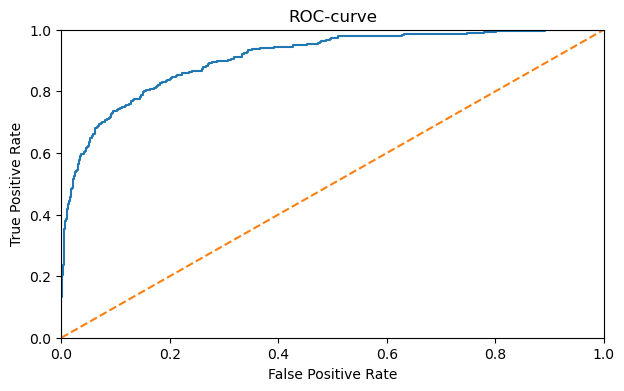

AUC-ROC= 0.9078526328694907


In [62]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)

plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()
print("AUC-ROC=", auc_roc_cb)

### Confusion matrix

<Figure size 640x480 with 0 Axes>

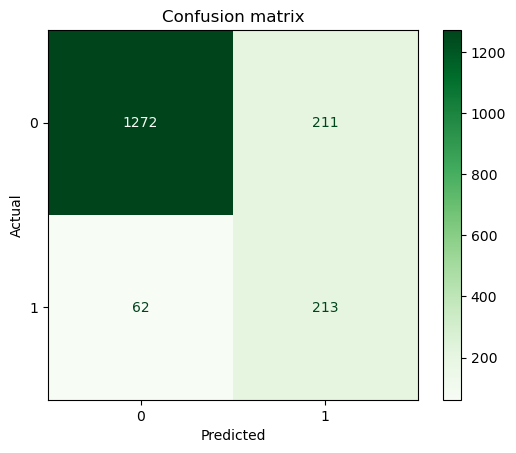

In [63]:
probabilities = best_model.predict(features_test)
cm=confusion_matrix(target_test, probabilities)
plt.figure()
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Greens)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

### Importance of features of the best model

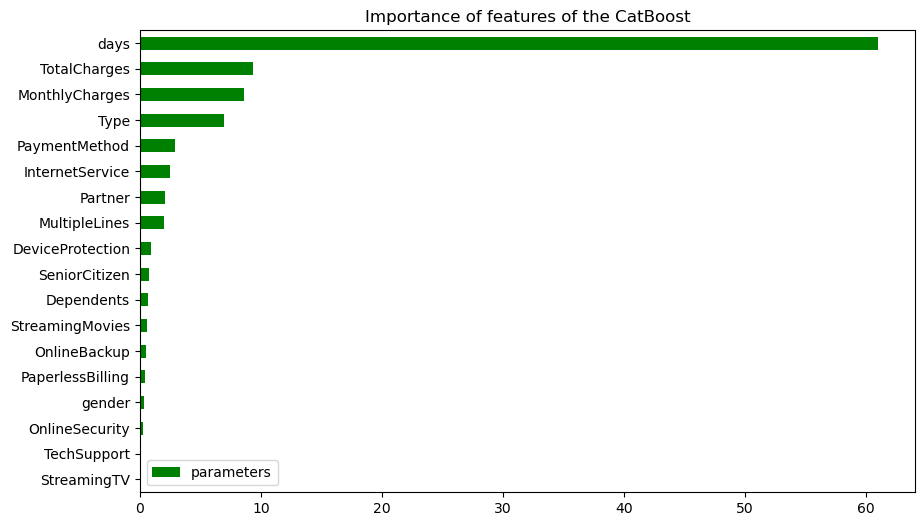

In [64]:
parameters = pd.DataFrame(best_model.feature_importances_, index = features_train.columns, columns=['parameters'])
parameters = parameters.sort_values(by='parameters')
parameters.plot(kind='barh', figsize=(10, 6), title='Importance of features of the CatBoost', color='green')
plt.show()

## Brief intermediate conclusion

The CatBoost model performed best. We managed to achieve an AUC-ROC of 0.896 on the training set, and 0.907 on the test set. The model quickly learns and produces the required result.

In the error matrix we see that the model as a whole correctly predicts departing and remaining customers. But the number of false positive responses is relatively high (211). In this case, the business does not lose the client, but suffers losses on promotions and discounts, although in this case they were not required. The model failed to predict 62 customer churn, which is relatively low.

The most important parameter for the resulting model is the duration of the client’s “lifetime” (the period of use of services in days). It is now obvious why, after correcting this parameter, the quality of the model increased sharply and it was possible to achieve the desired indicator. Less important are the type of payment, monthly and total expenses. And additional services have virtually no effect on the model’s prediction.

## Solution report

### Which points of the plan were completed and which were not?

The main points from the original plan were completed and it was possible to create a working model that predicts user behavior for a telecommunications company with an accuracy that satisfies the customer.

At the first stage, a study of the source data was carried out, which turned out to be of high quality, but small in size (7000 lines). It became clear that the sample was representative and the company had difficulties selling additional services (more than half of the clients did not use any of the additional options).

At the second stage, it became clear that it was necessary to combine 4 dataframes into a single one, since they all have a common feature in the form of a client identifier. Next, preprocessing was carried out (more details in paragraph 8.5), division into samples, as well as encoding and scaling. Coding was performed only for the Logistic Regression model, since for 2 models with boosting they can work with uncoded data.

At the third stage, the Logistic Regression, CatBoostClassifier and LGBMClassifier models were trained, and hyperparameters for them were selected. (more details about the best model and its hyperparameters in paragraph 8.4)

Next, the best model, CatBoost, was tested on a test sample. An ROC curve, an error matrix, and a graph showing the importance of each feature for learning were constructed. Thus, we were convinced that the model works adequately and how much its quality depends on the degree of customer loyalty (how long he uses / has used the operator’s services).

In the future, you can further explore the combined dataframe to create a portrait of the user, as well as better understand age groups and preferences of people (depending on this, you can offer various additional services).

### Difficulties encountered and how I dealt with them

The first problem arose with the creation of an additional attribute in the form of duration of use of services. Due to my carelessness with the date of uploading dataframes, incorrect data was indicated for current clients. The models began to behave incorrectly, and without this indicator it was impossible to achieve the required indicator. After reading the conditions again, I corrected the date and the CatBoost model immediately exceeded the required AUC_ROC indicator.

The second problem was the encoding of dataframes. Boosting models do not require encoding, but only passing a list of categorical features or changing their type (depending on the model). For logistic regression, it was necessary to use OneHotEncoding, which I had not used before (I used Ordinal). Thanks to examples and comments from the team lead, I understood these two sub-points and improved the quality of work of all three models.

### Key steps in solving the problem

1. **Data Research**
    
     No project can be undertaken without understanding the available data and its quality.


2. **Data preparation**

     After analysis and identification of problems, gaps are dealt with, data types are changed, scaling and coding are carried out for different models. The data is also divided into a training and test set in order to correctly check the quality of the resulting model.
    
    
3. **Model training**

     All three models are trained with the selection of optimal hyperparameters.
    

4. **Analysis of the results**

     The adequacy of the model is checked, its operation on a test sample, and the parameters that most influence the final result are studied.

### What is the final model, what are the hyperparameters and what is the quality?

In [65]:
columns=['Logistic Regression', 'CatBoostClassifier', 'LGBMClassifier']
info={'AUC-ROC':[lr.best_score_, cat_boost.best_score_, light_gbm.best_score_]}
final_result=pd.DataFrame(data=info, index=columns)
final_result = final_result.sort_values(by='AUC-ROC', ascending=False)
final_result

,AUC-ROC
CatBoostClassifier,0.896332
LGBMClassifier,0.861290
Logistic Regression,0.764596


In [66]:
print("Best parameters:", cat_boost.best_params_)

Best parameters: {'depth': 3, 'iterations': 200, 'learning_rate': 0.3}


Last place was taken by the Logistic Regression model with a result approximately 15% worse than that of the boosting models. LGBM and Catboost have similar results, but CatBoostClassifier still outperforms its competitor.

Using GridSearchCV, we selected the best hyperparameters, in particular learning rate and depth. The best parameters turned out to be: learning rate equal to 0.3, depth - 3, number of iterations - 200.

On the training set, CatBoost showed a result of **0.896**, and when checking on the test set - **0.907**

### Features used to train the best model and their preprocessing

In [67]:
parameters.sort_values(by='parameters', ascending=False)

,parameters
days,60.989175
TotalCharges,9.389364
MonthlyCharges,8.610306
Type,6.919863
PaymentMethod,2.904336
InternetService,2.524885
Partner,2.046169
MultipleLines,2.008212
DeviceProtection,0.958107
SeniorCitizen,0.740399


In total, 18 parameters were used to train CatBoost, 3 of them were numerical (days, TotalCharges and MonthlyCharges), and the rest were categorical.

1. The gaps in the categorical fields were filled in. If there is no data, then the client does not use this service and money for it is not debited, so it is worth filling in these 'No' fields.
2. The TotalCharges parameter type has been replaced with a numeric one for correct operation.
3. Using the BeginDate and EndDate parameters, a new one was created - days, showing how long the client has been using or has used the company’s services. The original columns have been removed.
4. For the CatBoost model, a list of categorical variables was passed, since this model can work on uncoded samples.
4. Target attribute - lost_client. Was created based on the EndDate parameter. If there was a contract expiration date, then the attribute is equal to 1, otherwise 0.